# Tensorflow Expedia plus features

In [ ]:
!pip install tensorflow_recommenders

In [1]:
import os
import pprint
import tempfile

from typing import Dict, Text

import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

import tensorflow_recommenders as tfrs

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Load data

In [32]:
df.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

In [34]:
data_dir = '../data/expedia/'

def convert_date(date_col):
    return (pd.to_datetime(date_col) - dt.datetime(1970,1,1)).dt.total_seconds()

def convert_features(df: pd.DataFrame) -> pd.DataFrame:
    
    # Convert date to unix timestamp
    df['date_time'] = convert_date(df['date_time'])
    
    # Convert to bytes
    df['user_id'] = [bytes(str(uid), 'utf-8') for uid in df['user_id']]
    
    df = df.drop(['srch_ci', 'srch_co'], axis=1)
    
    if 'hotel_cluster' in df.columns:
        df['hotel_cluster'] = [bytes(str(uid), 'utf-8') for uid in df['hotel_cluster']]
        df = df.drop(['cnt'], axis=1)
    
    return df
    

def create_tf_datasets(df: pd.DataFrame):
            
    features = convert_features(df)
        
    # Create tf datasets
    dataset = tf.data.Dataset.from_tensor_slices((dict(features))) 
    hotels = tf.data.Dataset.from_tensor_slices([bytes(str(uid), 'utf-8') for uid in range(0, 99)])
        
    # Column selection
    dataset = dataset.map(lambda x: {
        "hotel_cluster": x["hotel_cluster"],
        "user_id": x["user_id"],
        "is_package" : x["is_package"],
        "srch_adults_cnt" : x["srch_adults_cnt"],
        "srch_children_cnt": x["srch_children_cnt"]
    })
    
    return dataset, hotels, len(df)
    
def create_tf_test_dataset(df: pd.DataFrame):
    
    features = convert_features(df)
    
    dataset = tf.data.Dataset.from_tensor_slices((dict(features))) 

    return dataset.map(lambda x: {
        "user_id": x["user_id"],
        "is_package" : x["is_package"],
        "srch_adults_cnt" : x["srch_adults_cnt"],
        "srch_children_cnt": x["srch_children_cnt"],

    })    

In [35]:
filename = 'train_sample' # 'train_sample' 'train_bookings'

df = pd.read_csv(data_dir + f'{filename}.csv')

dataset, hotels, n_records = create_tf_datasets(df)

## Colab load data

### Manual upload

In [ ]:
# Upload Colab per file
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
    
df = pd.read_csv(io.StringIO(uploaded['train_sample.csv'].decode('utf-8')))

### Load from Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

#changing the working directory
%cd /content/gdrive/My Drive/kaggle
#Check the present working directory using pwd command
pwd()

In [ ]:
# Download the Kaggle dataset in case
!kaggle competitions download -c expedia-hotel-recommendations
!unzip \*.zip  && rm *.zip

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
dataset, hotels, n_records = create_tf_datasets(df)

## Parse data

In [6]:
for x in dataset.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'hotel_cluster': b'15',
 'is_package': 0,
 'srch_adults_cnt': 1,
 'user_id': b'472333'}


In [7]:
user_ids = dataset.batch(1_000_000).map(lambda x: x["user_id"])
hotel_clusters = hotels.batch(1_000_000)

unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_hotel_clusters = np.unique(np.concatenate(list(hotel_clusters)))

unique_hotel_clusters[:10]

array([b'0', b'1', b'10', b'11', b'12', b'13', b'14', b'15', b'16', b'17'],
      dtype=object)

In [8]:
is_package = np.concatenate(list(dataset.map(lambda x: x["is_package"]).batch(100)))

In [12]:
srch_adults = np.unique(np.concatenate(list(dataset.map(lambda x: x["srch_adults_cnt"]).batch(100))))

In [36]:
srch_children = np.unique(np.concatenate(list(dataset.batch(1_000_000).map(lambda x: x["srch_children_cnt"]))))

## Model

Indicator columns and embedding columns never work on features directly

https://keras.io/guides/preprocessing_layers/

In [37]:
class UserModel(tf.keras.Model):
  
    def __init__(self):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
        ])

        self.package_encoder = (tf.keras
                                .layers.experimental
                                .preprocessing
                                .CategoryEncoding(output_mode="binary"))
        
        self.package_encoder.adapt(is_package)
        
        self.adults_cnt_normalizer = (tf.keras.layers
                                      .experimental.preprocessing
                                      .Normalization())
        
        self.adults_cnt_normalizer.adapt(srch_adults)
        
        self.children_cnt_normalizer = (tf.keras.layers
                                      .experimental.preprocessing
                                      .Normalization())
        
        self.children_cnt_normalizer.adapt(srch_children)


    def call(self, inputs):

        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.package_encoder(inputs["is_package"]),
            self.adults_cnt_normalizer(inputs['srch_adults_cnt'])
        ], axis=1)

In [38]:
# Candidate tower
class HotelClusterModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        self.hotel_clusters = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_hotel_clusters, mask_token=None),
          tf.keras.layers.Embedding(len(unique_hotel_clusters) + 1, embedding_dimension)
        ])
        
    def call(self, hotel_cluster):
        return self.hotel_clusters(hotel_cluster) 


In [63]:
embedding_dimension = 32

# top K categorical accuracy: how often the true candidate is in the top K candidates for a given query.

In [65]:
class ExpediaModel(tfrs.Model):

    def __init__(self, layer_sizes: list):
        super().__init__()
        self.hotel_cluster_model: tf.keras.Model = HotelClusterModel()
        
        self.user_model: tf.keras.Model = tf.keras.Sequential()
            
        self.user_model.add(UserModel())
        
        for layer_size in layer_sizes:
            self.user_model.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        self.user_model.add(tf.keras.layers.Dense(32))
        
        metrics = tfrs.metrics.FactorizedTopK(
          candidates=hotels.batch(128).map(self.hotel_cluster_model)
        )

        self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
          metrics=metrics
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pass the features to the user model
        user_embeddings = self.user_model(features)
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_hotel_clusters = self.hotel_cluster_model(features['hotel_cluster'])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_hotel_clusters)

In [66]:
model = ExpediaModel(layer_sizes=[])
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [67]:
# TODO timesplit
tf.random.set_seed(42)
shuffled = dataset.shuffle(n_records, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(int(0.915 * n_records))
test = shuffled.skip(int(0.95 * n_records)).take(int(0.05 * n_records))

cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
fitted_model = model.fit(cached_train, 
          validation_data=cached_test,
          validation_freq=1,
          epochs=2)

Epoch 1/2
22/56 [==========>...................] - ETA: 15s - factorized_top_k: 0.3677 - factorized_top_k/top_1_categorical_accuracy: 0.0117 - factorized_top_k/top_5_categorical_accuracy: 0.0762 - factorized_top_k/top_10_categorical_accuracy: 0.1456 - factorized_top_k/top_50_categorical_accuracy: 0.6051 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 73491.6839 - regularization_loss: 0.0000e+00 - total_loss: 73491.6839

In [47]:
model.evaluate(cached_test, return_dict=True)

7/7 [==============================] - 1s 80ms/step - factorized_top_k: 0.4031 - factorized_top_k/top_1_categorical_accuracy: 0.0305 - factorized_top_k/top_5_categorical_accuracy: 0.1222 - factorized_top_k/top_10_categorical_accuracy: 0.2002 - factorized_top_k/top_50_categorical_accuracy: 0.6625 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 32244.5696 - regularization_loss: 0.0000e+00 - total_loss: 32244.5696


{'factorized_top_k': array([0.03048, 0.12224, 0.20024, 0.66248, 1.     ], dtype=float32),
 'factorized_top_k/top_1_categorical_accuracy': 0.030479999259114265,
 'factorized_top_k/top_5_categorical_accuracy': 0.12223999947309494,
 'factorized_top_k/top_10_categorical_accuracy': 0.20024000108242035,
 'factorized_top_k/top_50_categorical_accuracy': 0.6624799966812134,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 3322.0361328125,
 'regularization_loss': 0,
 'total_loss': 3322.0361328125}

Top-1 accuracy: 0.03.


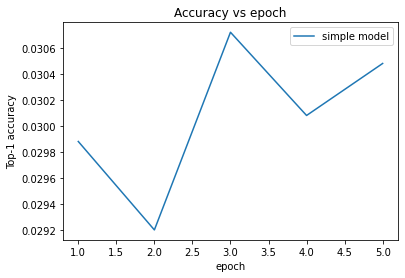

In [49]:
accuracy = fitted_model.history["val_factorized_top_k/top_1_categorical_accuracy"][-1]
print(f"Top-1 accuracy: {accuracy:.2f}.")

num_validation_runs = len(
fitted_model.history["val_factorized_top_k/top_1_categorical_accuracy"])
epochs = [(x + 1)* 1 for x in range(num_validation_runs)]

plt.plot(epochs, fitted_model.history["val_factorized_top_k/top_1_categorical_accuracy"], label="simple model")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-1 accuracy");
plt.legend();

### Save model

In [113]:
# Save model
query_path = os.path.join('./models/', f"{filename}_package_query_model")
model.user_model.save(query_path)

candidate_path = os.path.join('./models/', f"{filename}_package_candidate_model")
model.hotel_cluster_model.save(candidate_path)

In [114]:
os.getcwd()

'/Users/wf07pu/Documents/workspace/Kaggle_expedia/deep-learning'

In [29]:
model.user_model(list(cached_test.take(1))[0])

<tf.Tensor: shape=(4096, 32), dtype=float32, numpy=
array([[-0.11536495, -0.35532725, -0.29341123, ..., -0.12003823,
        -0.1506847 ,  0.13403347],
       [-0.06841899,  0.12776509, -0.00734759, ...,  0.16686675,
        -0.39123264, -0.13943402],
       [-0.25987336, -0.0114258 ,  0.34444422, ...,  0.6702015 ,
        -0.53774613, -0.5448187 ],
       ...,
       [-0.18969959, -0.41773486, -0.13887192, ...,  0.1610161 ,
         0.07017141,  0.25148642],
       [-0.3093794 ,  0.13931379, -0.14610325, ...,  1.1008857 ,
         0.11728058, -0.13133314],
       [-0.08509706, -0.39110804, -0.23782617, ..., -0.10203935,
         0.02522854,  0.19742453]], dtype=float32)>

In [121]:
# Load model
filename = 'train_sample'
query_path = os.path.join('./models/', f"{filename}_package_query_model")
user_model = tf.keras.models.load_model(query_path)

candidate_path = os.path.join('./models/', f"{filename}_package_candidate_model")
candidate_model = tf.keras.models.load_model(candidate_path)

## Predictions

In [ ]:
df = pd.read_csv(data_dir + 'test.csv')

In [ ]:
final_test_set = create_tf_test_dataset(df)
final_test_set_cached = final_test_set.batch(4096)

In [ ]:
cached_final_test_set = final_test_set.batch(8192).cache()

In [ ]:
user_embeddings = model.user_model.predict(cached_final_test_set)

user_embeddings.shape

### Brute Force

In [ ]:
# Create a model that takes in raw query features, and
# index_bruteforce = tfrs.layers.factorized_top_k.BruteForce()

index_bruteforce = tfrs.layers.ann.BruteForce()

hotel_cluster_embeddings = hotels.batch(100).map(model.hotel_cluster_model)

# recommends hotels from all hotel clusters.
index_bruteforce.index(candidates=hotel_cluster_embeddings, 
                      identifiers=hotels)

brute_force_result = index_bruteforce(queries=user_embeddings)[1].numpy()

results = [[str(int(i))
 for i 
 in query[:5]]
 for query
 in brute_force_result
]

In [ ]:
pd.DataFrame({'id': df['id'], 'hotel_cluster': [' '.join(result) for result in results]}).to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c expedia-hotel-recommendations -f submission.csv -m "First tensorflow-recommender approach"

## Archive

In [ ]:
_, hotel_cluster = index(queries={'user_id':tf.constant(["472333"]), 
                                   'is_package': tf.constant([1])})
print(f"Recommendations for user 472333: {hotel_cluster[0, :3]}")

In [ ]:
users_to_predict

In [ ]:
results = []

for i, user in users_to_predict.iterrows():
    _, hotel_clusters = index(queries={'user_id':tf.constant([str(user['user_id'])]), 
                                       'is_package': tf.constant([user['is_package']])})
    results.append({'user_id': user['user_id'], 'hotel cluster' : [int(i) for i in hotel_clusters[0, :5].numpy()]})
    if i % 1_000 == 0:
        print(f"Parsed {i} users.")

In [ ]:
pd.DataFrame(results)

### Brute force per record

Too slow and yields the same result

In [ ]:
# Create a model that takes in raw query features, and
index_bruteforce = tfrs.layers.ann.BruteForce(query_model=model.user_model)

hotel_cluster_embeddings = hotels.batch(100).map(model.hotel_cluster_model)

# recommends hotels from all hotel clusters.
index_bruteforce.index(candidates=hotel_cluster_embeddings, 
                      identifiers=hotels)

results_bruteforce = []

for row in final_test_set.batch(1).take(5_00):
    _, hotel_cluster = index_bruteforce(queries=row)
    results_bruteforce.append([int(i) for i in hotel_cluster.numpy()[0][:5]])

### Annoy

Uses NNeirest neighbours for the items. Because we 'only' have 100 items (=hotel clusters), the computational benefit does not differ much from brute force.

In [ ]:
from annoy import AnnoyIndex

index = AnnoyIndex(embedding_dimension, "dot")

hotel_embeddings = hotels.enumerate().map(lambda idx, cluster: (idx, cluster, model.hotel_cluster_model(cluster)))
hotel_embeddings

# We unbatch the dataset because Annoy accepts only scalar (id, embedding) pairs.
for hotel_id, _, hotel_embedding in hotel_embeddings.as_numpy_iterator():
    index.add_item(hotel_id, hotel_embedding)

# Build a 10-tree ANN index.
index.build(10)

results = []

for i, row in enumerate(final_test_set.batch(1).take(len(final_test_set))):
    query_embedding = model.user_model(row)[0]
    results.append(index.get_nns_by_vector(query_embedding, 5))
    print(query_embedding)
    if i % 10_000 == 0:
        print(f"Parsed {i} users.")
        
# import pickle

# with open("./results_230_000.txt", "wb") as fp:   #Pickling
#     pickle.dump(results, fp)